# Visualising the database using iGraph

In [5]:
import pandas as pd 
import numpy as np
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.model_selection
import sklearn.cluster
import matplotlib
from matplotlib import pyplot as plt
import py2neo
import seaborn as sb ##includes convenient heatmaps and boxplots
import scipy as sp
import pylab as pl
import igraph
import cairocffi as cairo

In [6]:
def query_database(query):
    # REMEMBER TO BE CONNECTED TO IMPERIAL WIFI!
    graph_db = py2neo.Graph("https://dsi-bitcoin.doc.ic.ac.uk:7473/db/data/", auth=("guest_ro", "imperialO_nly"))
    return graph_db.run(query)

def get_block_data(first_block, last_block):
    query_string = """
                    MATCH (b:Block) <-[:MINED_IN]- (t:Tx) <-[:IN]- (txi:TxIn) <-[:UNLOCK]- (iadr:Address)
                    WHERE b.height >= {} AND b.height <= {}
                    MATCH (txi) <-[:SPENT]- (txo_in:TxOut) 
                    MATCH (oadr:Address) <-[:LOCK]- (txo_out:TxOut) <-[:OUT]- (t) 
                    
                    RETURN iadr.address as iadr, oadr.address as oadr, txo_in.value as input_val, txo_out.value as output_val, ID(txo_in) as id_txo_in, ID(txi) as id_txi, ID(t) as id_t, ID(txo_out) as id_txo_out
                    
                    """.format(first_block, last_block)
    return query_string

In [49]:
result = query_database(get_block_data(400000,400000))
df = result.to_data_frame()
#df = pd.read_csv('block_400000.csv')
#df[[col for col in df.columns if not 'Unnamed' in col]]

# tups1 = []
# tups2 = []
# for d in result:
#     tups1.append((d['iadr'],d['oadr']))

## Finding users by using heuristic measures

## Heuristic 1

In [50]:
from collections import defaultdict

#CHANGE LATER TO QUERY DATABASE INSTEAD
def iadrs_from_tx(id_t):
    return set(df['iadr'][df["id_t"] == id_t])

def oadrs_from_tx(id_t):
    return set(df['oadr'][df["id_t"] == id_t])

def tx_from_iadr(iadr):
    return set(df['id_t'][df["iadr"] == iadr])

#FUNCTION TO WHICH YOU GIVE AN INPUT ADDRESS AND GET USER 
def get_user(input_adr):
    to_inv = [input_adr]
    user_iadrs = set()
    seen_txs = set()
    while to_inv:
        current_iadr = to_inv.pop(0)
        user_iadrs.add(current_iadr)
        for id_t in tx_from_iadr(current_iadr):

            if id_t not in seen_txs:
                
                seen_txs.add(id_t)
                iadrs = iadrs_from_tx(id_t)
                to_inv += iadrs.difference(user_iadrs) #Adding addr
                user_iadrs.update(iadrs)
            
    return User(user_iadrs, seen_txs)

#LIST OF LISTS OF USER AND THEIR ASSOCIATED ADDRESSES
users = []

class User:
    def __init__(self, adrs, txs):
        self.adr = set(adrs)
        self.tx = set(txs)
        self.cadr = set()

# Bitcoin- 
bitcoin = User({str(0)}, set()) #Make user object with bitcoin iadr (which is 0)
seen_miner_iadrs_tx = defaultdict(set) #Make dict associating miner payment address with tx_ids they've been involved in

for index, row in df[df['iadr'] == str(0)].iterrows(): #Going through all mining txs 
    bitcoin.tx.add(row['id_t']) #Adding tx id to bitcoin user's txs
    seen_miner_iadrs_tx[row['oadr']].add(row['id_t']) # Updating dict to register the tx_id as corresponding to miners adr. If new, then new key added, otherwise added to values of existing key
    
users.append(bitcoin) # Add bitcoin user
already_seen_iadr = {str(0)}  # Bitcoin iadr has already been seen

# make miners users
for adr, id_ts in seen_miner_iadrs_tx.items(): #Go through dictionary for every adr (miner) and txs he's been involved
    miner = get_user(adr) #From an address, give back user ... aka identify all addresses belonging to miner
    miner.adr.add(adr) #Make sure adrs and txs are added in
    miner.tx.update(id_ts)
    users.append(miner)
    already_seen_iadr.update(miner.adr)#Made sure miner's addresses are in already seen so that we don't create a second user with the same addresses
    

## ASSOCIATE INPUT ADDRESS AND TX WITH EACH USER IN BLOCK
# make other users from heuristic
for input_adr in df.iadr:
    if input_adr not in already_seen_iadr:
        user = get_user(input_adr)
        users.append(user)
        already_seen_iadr.update(user.adr)


#TAKES OUTPUT ADDRESS AND GIVES USER THAT HAS THAT ADDRESS AS INPUT
def user_from_oadr(oadr):
    for i,user in enumerate(users):
        if oadr in user.adr:
            return i
        
edges = defaultdict(int)

#WHICH USERS IN HAVE TRANSACTED WITH EACH OTHER
for i,user in enumerate(users):
    for tx_id in user.tx:
        for oadr in oadrs_from_tx(tx_id):
            if oadr in already_seen_iadr:

                    edges[(i, user_from_oadr(oadr))]+=1  
            

## Heuristic 2

In [52]:
import pickle
with open ('outfile', 'rb') as fp:
    not_seen = pickle.load(fp)
    
appeared_once_o= list(df.oadr.value_counts()[df.oadr.value_counts()==1].index)
all_iadrs= list(df.iadr.value_counts().index)

o_never_used_as_i = set(appeared_once_o).difference(all_iadrs)

In [53]:
from collections import Counter

tx_ids = []
for user in users[1:]:#Drop out bitcoin user
    tx_ids += list(user.tx)

#tx_ids = list.append([list(user.tx) for user in users])
        
ads = []
for i,user in enumerate(users):
    for ad in user.adr:
        ads.append(ad)
        
cads = []
for i,user in enumerate(users):
    for cad in user.cadr:
        cads.append(cad)

if Counter(tx_ids).most_common(10)[0][1] == 1:  ##Repeated txids between bitcoin and the miners
    print("No repeats txid")
    
if Counter(ads).most_common(10)[0][1] == 1:
    print("No repeats ads")

No repeats txid
No repeats ads


In [54]:
for i,user in enumerate(users):
    temp = set()
    for tx_id in user.tx:
        o = oadrs_from_tx(tx_id)
        potential_cadr = []
        for oadr in o:
            if oadr in not_seen and oadr in o_never_used_as_i:
                potential_cadr.append(oadr)
        if len(potential_cadr)==1:
            temp.add(potential_cadr[0])
    user.cadr.update(temp)   

In [ ]:
df.groupby('id_t').agg({'oadr':['nunique', 'count'],'iadr':['nunique', 'count'],'id_txo_in':['nunique', 'count'],'id_txo_out':['nunique', 'count']})

df.to_csv('users.csv', columns=['input_user','output_user'])

## Construct User Graph

In [55]:
#Construct User Graph
df['input_user'] = df['iadr']
df['output_user'] = df['oadr']
for i, user in enumerate(users):
    assert(isinstance(i, int))
    df['input_user'] = df['input_user'].apply(lambda x: i if x in user.adr else x)
    df['output_user'] = df['output_user'].apply(lambda x: i if x in user.adr else x)
    df['output_user'] = df['output_user'].apply(lambda x: i if x in user.cadr else x)

# can't trust input_val column now
# because dropped lots of inputs
df_new = df.drop_duplicates(['input_user', 'id_txo_out'])
df_new = df_new.groupby(['input_user', 'output_user']).apply(lambda group: group['output_val'].sum()).reset_index()
tups = []
for i in range(0, df_new.shape[0]):
    tups.append((df_new.at[i, 'input_user'],df_new.at[i, 'output_user']))

In [ ]:
df.head()
df['iadr'].apply(type).value_counts()

## User Feature Extraction

In [62]:
# New columns for number of input and output transaction ids
df['num_txo'] = df.groupby('id_t')['id_txo_out'].transform('nunique')
df['num_txi'] = df.groupby('id_t')['id_txi'].transform('nunique')

In [135]:
# user input features
user_input_df = df.groupby('input_user').agg({
    'id_txo_out': 'nunique', #Num unique times paid out
    'oadr':'nunique', #Num of unique out addresses paid out
    'output_user': 'nunique', #Num of unique users paid out (Out Degree)
    #'id_txi': 'nunique', #Num unique times paid in
    'id_t': 'nunique', #Num Txs involved in
    'input_val': ['max', 'min']
})

user_input_df.columns = ['_'.join(col) for col in user_input_df.columns]

user_input_df.rename(columns={
    'id_txo_out_nunique': 'unique_sent',
    'oadr_nunique': 'unique_sent_adr',
    'output_user_nunique': 'unique_sent_user',  # (Out Degree)
    'id_t_nunique': 'tx1',
    'input_val_max': 'max_sent',
    'input_val_min': 'min_sent'
}, inplace=True)

user_input_df['total_sent'] = (df['input_val'] / df['num_txo']).groupby(df['input_user']).sum()
#dummy1 = (df['input_val'] / df['num_txo']).groupby(df['input_user']).sum()
#dummy2 = (df['output_val'] / df['num_txi']).groupby(df['input_user']).sum()

#print(user_df.tail())

user_input_df.head()

,unique_sent,unique_sent_adr,unique_sent_user,tx1,max_sent,min_sent,total_sent
input_user,,,,,,,
1,1,1,1,1,2.328040,0.984900,9.385590
2,1,1,1,1,1.713700,1.250300,8.963390
3,1,1,1,1,0.064797,0.003142,0.233997
4,1,1,1,1,0.400641,0.239484,2.065325
5,1,1,1,1,1.348410,0.000200,4.046738


In [136]:
# user output features
user_out_df = df.groupby('output_user').agg({
    'id_txi': 'nunique', #Num unique times paid in
    'iadr': ['nunique', lambda x: (x == str(0)).any()], #Num of unique in addresses paid this user
    'input_user': 'nunique', #Num of unique users paid in (In Degree)
    #'id_txo_out': 'nunique', #Num unique times paid
    'id_t': 'nunique', #Num Txs involved in
    'output_val': ['max', 'min']
})

user_out_df.columns = ['_'.join(col) for col in user_out_df.columns]

user_out_df.rename(columns={
    'id_txi_nunique': 'unique_rec',
    'iadr_nunique': 'unique_rec_adr',
    'iadr_<lambda>': 'is_miner',
    'input_user_nunique': 'unique_rec_user',  # (In Degree)
    'id_t_nunique': 'tx2',
    'output_val_max': 'max_rec',
    'output_val_min': 'min_rec'
}, inplace=True)

user_out_df['total_rec'] = (df['output_val'] / df['num_txi']).groupby(df['output_user']).sum()

user_out_df.head()

,unique_rec,unique_rec_adr,is_miner,unique_rec_user,tx2,max_rec,min_rec,total_rec
output_user,,,,,,,,
1,6,6,False,2,2,9.430000,0.165496,9.595496
13,2,2,False,2,2,5.822000,5.026000,10.848000
58,1,1,False,1,1,0.002605,0.002605,0.002605
59,2,2,False,2,2,0.003954,0.001324,0.005278
60,2,2,False,2,2,0.005303,0.001324,0.006627


In [137]:
# Merge input and output user features
user_df = user_input_df.merge(user_out_df, how='left', left_index=True, right_index=True)

# Append miners
user_df = user_df.append(user_out_df[user_out_df['is_miner']], sort=True)

# Name index
user_df.index.name = 'user'

# Fill in NA values
user_df['is_miner'].fillna(False, inplace=True)
user_df.fillna(0, inplace=True)

# New columns
user_df['num_tx'] = user_df['tx1'] + user_df['tx2']
# user_df = user_df.drop(['tx1', 'tx2'], axis=1)

In [125]:
# Totals
total_amt_spent = (df['input_val'] / df['num_txo']).sum() ##Total amount spent in this block?
total_amt_recieved = (df['output_val'] / df['num_txi']).sum() ##Total amount received in this block?

## Clustering

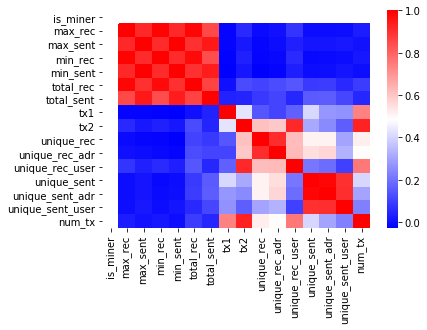

In [139]:
#Normalize data

scaler = sklearn.preprocessing.StandardScaler()
scaled_cluster = scaler.fit_transform(user_df)
cluster_scaled = pd.DataFrame(scaled_cluster, columns=user_df.columns, index=user_df.index)


data_corr = cluster_scaled.corr()
sb.heatmap(data_corr, cmap = 'bwr') #heatmap of correlation matrix

<function matplotlib.pyplot.show(*args, **kw)>

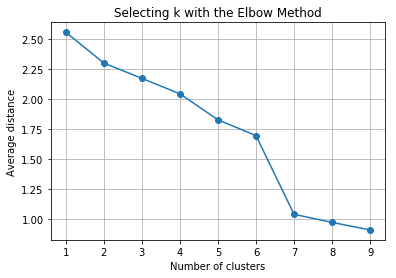

In [142]:
#split data into train and test sets
clus_train, clus_test = sklearn.model_selection.train_test_split(cluster_scaled, test_size=0.3, random_state=123)

clusters = range(1,10)
meandist=[]

for k in clusters:
    model = sklearn.cluster.KMeans(n_clusters = k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(sp.spatial.distance.cdist(clus_train,model.cluster_centers_,'euclidean'),axis=1))/clus_train.shape[0])
    
plt.plot(clusters, meandist, '-o')
#plt.subplot(2,1,1)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show

# # Convert DataFrame to matrix
# mat = cluster_scaled.values
# distorsions = []
# x = range(2, 20)
# for k in x:
#     #Perform K Means
#     kmeans = sk.cluster.KMeans(n_clusters=k)
#     kmeans.fit(mat)
#     distorsions.append(kmeans.inertia_)

# fig = plt.figure(figsize=(15, 5))
# plt.plot(x, distorsions)
# plt.grid(True)
# plt.title('Elbow curve')
# plt.show
# plt.xticks(x)

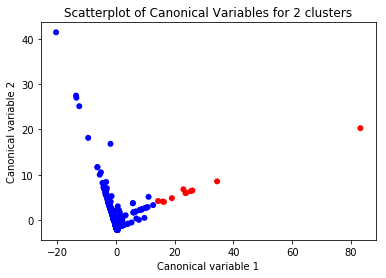

In [143]:
plt.gcf().clear()
model = sklearn.cluster.KMeans(n_clusters = 2)
model.fit(clus_train)
clusassign = model.predict(clus_train)

colors = ['red', 'blue']

#Principal Component Analysis
pca_2 = sklearn.decomposition.PCA(2)
plot_columns = pca_2.fit_transform(clus_train)    
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1],c=model.labels_,cmap = matplotlib.colors.ListedColormap(colors),edgecolors = 'none')
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 clusters')
plt.show


# Get cluster assignment labels
labels = model.labels_
# Format results as a DataFrame
data = {'transaction_id':clus_train.index,'cluster_label':labels}
results = pd.DataFrame(data)